# Canister Damage Detection — Strict Mask + Border Cleanup + Red Boxes (v4)
**Date:** 2025-10-04

This version:
- Uses **SAM (if available) or seeded GrabCut** to segment the canister, then **post-processes** masks to remove corner/border leaks.
- **Normalizes mask polarity** so canister=255, background=0 (no heat outside canister).
- **Tight-crops** ROI to the mask (orientation preserved).
- Trains **PatchCore-lite** on masked patches only and draws **red boxes** over anomalous regions.


## 0) Setup

In [ ]:
!pip -q install timm opencv-python-headless scikit-learn
# Optional SAM:
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!wget -q -O /content/sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Create necessary directories
!mkdir -p data/raw
!mkdir -p data/roi
!mkdir -p data/output

import os, glob, math, random
from typing import Tuple, List, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
import cv2, torch, timm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix

try:
    from segment_anything import sam_model_registry, SamPredictor
    SAM_AVAILABLE = True
except Exception:
    SAM_AVAILABLE = False

print('SAM available:', SAM_AVAILABLE)


# Download SAM checkpoint (Windows-compatible)
if SAM_AVAILABLE:
    SAM_CHECKPOINT = './sam_vit_b_01ec64.pth'
    
    if not os.path.exists(SAM_CHECKPOINT):
        print(f'\n📥 Downloading SAM checkpoint (~375MB)...')
        print(f'   Saving to: {SAM_CHECKPOINT}')
        
        try:
            import urllib.request
            
            def download_progress(block_num, block_size, total_size):
                downloaded = block_num * block_size
                percent = min(100, downloaded * 100 / total_size)
                print(f'\r   Progress: {percent:.1f}% ({downloaded / 1024 / 1024:.1f}MB / {total_size / 1024 / 1024:.1f}MB)', end='')
            
            url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
            urllib.request.urlretrieve(url, SAM_CHECKPOINT, download_progress)
            print('\n   ✓ Download complete!')
            
        except Exception as e:
            print(f'\n   ❌ Download failed: {e}')
            print('   Please download manually from:')
            print('   https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth')
            SAM_AVAILABLE = False
    else:
        print(f'✓ SAM checkpoint found: {SAM_CHECKPOINT}')

print(f'\nSAM will be used for segmentation: {SAM_AVAILABLE and os.path.exists("./sam_vit_b_01ec64.pth")}')



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


SAM available: True
✓ SAM checkpoint found: ./content/sam_vit_b_01ec64.pth

SAM will be used for segmentation: True


'wget' is not recognized as an internal or external command,
operable program or batch file.


## 1) Config

In [ ]:
DATA_ROOT = './data'
RAW_DIR   = os.path.join(DATA_ROOT, 'raw')
ROI_DIR   = os.path.join(DATA_ROOT, 'roi')
FIG_DIR   = os.path.join('/content', 'figures')
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(ROI_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

SEG_MODE = 'sam' if SAM_AVAILABLE and os.path.exists('/content/sam_vit_b_01ec64.pth') else 'grabcut_seeds'
SAM_CHECKPOINT = '/content/sam_vit_b_01ec64.pth'
SAM_VARIANT = 'vit_b'

INPUT_SHORT = 640
BBOX_PAD_FRAC = 0.12
FG_INSET = 0.30
BG_MARGIN = 0.10

BORDER_KILL_PCT = 0.03
CLOSE_KS = 7
OPEN_KS  = 3
MIN_AREA_FRAC = 0.01

BACKBONE_CANDIDATES = ['vit_small_patch14_dinov2.lvd142m', 'resnet50']
FEATURE_OUT_INDEX = -1

KNN_K = 8
PSEUDO_OK_KEEP_PERCENT = 85
CORESET_FRAC = 0.02

TOPK_PERCENTILE = 95.0
TAU_METHOD = 'gaussian_ok'
TAU_PERCENTILE = 97.5
UNCERTAIN_BAND = 0.05

HEAT_CLIP = (90, 99)
ALPHA = 0.40
CONTOUR_PCT = 98.5
BOX_PERCENTILE = 98.5
BOX_MIN_AREA = 80
BOX_PAD = 6

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


## 2) Utilities

In [12]:
def load_image(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img

def save_image(path: str, img: np.ndarray):
    cv2.imwrite(path, img)

def photometric_normalize(img: np.ndarray) -> np.ndarray:
    img = img.astype(np.float32)
    eps = 1e-6
    avgB, avgG, avgR = [img[:,:,i].mean()+eps for i in range(3)]
    gray_avg = (avgB + avgG + avgR)/3.0
    gains = [gray_avg/avgB, gray_avg/avgG, gray_avg/avgR]
    wb = img.copy()
    for i,g in enumerate(gains): wb[:,:,i] *= g
    wb = np.clip(wb, 0, 255).astype(np.uint8)
    lab = cv2.cvtColor(wb, cv2.COLOR_BGR2Lab)
    L,A,B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L2 = clahe.apply(L)
    return cv2.cvtColor(cv2.merge([L2,A,B]), cv2.COLOR_Lab2BGR)

def normalize_mask_polarity(mask: np.ndarray, bbox: Tuple[int,int,int,int]=None) -> np.ndarray:
    m = mask
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    m = (m > 127).astype(np.uint8) * 255
    if bbox is not None:
        x1,y1,x2,y2 = bbox
        x1=max(0,x1); y1=max(0,y1); x2=min(m.shape[1]-1,x2); y2=min(m.shape[0]-1,y2)
        inside = m[y1:y2+1, x1:x2+1]
        white_ratio = (inside>127).mean() if inside.size>0 else (m>127).mean()
        if white_ratio < 0.5:
            m = 255 - m
    else:
        wr = (m>127).mean()
        if wr > 0.8 or wr < 0.1:
            m = 255 - m
    return m

def remove_border_components(m: np.ndarray, border_px: int = 2) -> np.ndarray:
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    m = (m > 127).astype(np.uint8) * 255
    h, w = m.shape
    rim = np.zeros_like(m, np.uint8)
    rim[:border_px, :] = 255; rim[-border_px:, :] = 255
    rim[:, :border_px] = 255; rim[:, -border_px:] = 255
    num, labels = cv2.connectedComponents((m > 0).astype(np.uint8))
    keep = np.zeros_like(m, np.uint8)
    if num <= 1:
        return keep
    rim_labels = np.unique(labels[rim > 0])
    for lab in range(1, num):
        if lab in rim_labels: continue
        keep[labels == lab] = 255
    return keep

def postprocess_canister_mask(mask: np.ndarray, bbox: tuple,
                              border_kill_pct: float = 0.03,
                              min_area_frac: float = 0.01,
                              close_ks: int = 7, open_ks: int = 3) -> np.ndarray:
    x1, y1, x2, y2 = bbox
    m = normalize_mask_polarity(mask, bbox)
    h,w = m.shape
    rim = max(1, int(round(border_kill_pct * min(h,w))))
    m[:rim, :] = 0; m[-rim:, :] = 0; m[:, :rim] = 0; m[:, -rim:] = 0
    sub = np.zeros_like(m); sub[y1:y2+1, x1:x2+1] = m[y1:y2+1, x1:x2+1]
    if close_ks > 0:
        sub = cv2.morphologyEx(sub, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(close_ks,close_ks)), 1)
    if open_ks > 0:
        sub = cv2.morphologyEx(sub, cv2.MORPH_OPEN,  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(open_ks,open_ks)), 1)
    cnts,_ = cv2.findContours(sub, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    keep = np.zeros_like(sub)
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        cv2.drawContours(keep, [c], -1, 255, thickness=cv2.FILLED)
    keep = remove_border_components(keep, border_px=rim)
    min_area = max(1, int(min_area_frac * (x2 - x1 + 1) * (y2 - y1 + 1)))
    final = np.zeros_like(keep)
    cnts,_ = cv2.findContours(keep, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        if cv2.contourArea(c) >= min_area:
            cv2.drawContours(final, [c], -1, 255, thickness=cv2.FILLED)
    return final


def overlay_heatmap_masked(img_bgr, heat, mask, alpha=0.4, clip_p=(90,99)):
    mask = normalize_mask_polarity(mask)
    mask01 = (mask.astype(np.float32)/255.0)
    heat_masked = heat * mask01
    valid = mask01 > 0
    if valid.any():
        hmin = np.percentile(heat_masked[valid], clip_p[0])
        hmax = np.percentile(heat_masked[valid], clip_p[1])
    else:
        hmin, hmax = 0.0, 1.0
    if hmax-hmin < 1e-8:
        norm = np.zeros_like(heat_masked, dtype=np.float32)
    else:
        norm = np.clip((heat_masked - hmin)/(hmax - hmin), 0, 1)
    norm8 = (norm*255).astype(np.uint8)
    color = cv2.applyColorMap(norm8, cv2.COLORMAP_JET)
    color = (color * mask01[...,None]).astype(np.uint8)
    return cv2.addWeighted(img_bgr, 1.0, color, alpha, 0)

def anomaly_boxes_from_heat(heat_up: np.ndarray, mask: np.ndarray,
                            percentile: float = 98.5, min_area_px: int = 80, pad_px: int = 6):
    mask = normalize_mask_polarity(mask)
    m01 = (mask > 0).astype(np.uint8)
    h_masked = heat_up * m01
    valid = m01 > 0
    thr = np.percentile(h_masked[valid], percentile) if valid.any() else np.percentile(h_masked, percentile)
    bw = (h_masked >= thr).astype(np.uint8) * 255
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 1)
    cnts,_ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H,W = mask.shape
    boxes=[]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h < min_area_px: continue
        x1=max(0, x-pad_px); y1=max(0, y-pad_px)
        x2=min(W-1, x+w+pad_px); y2=min(H-1, y+h+pad_px)
        boxes.append((x1,y1,x2,y2))
    return boxes

def draw_red_boxes(img_bgr: np.ndarray, boxes: list, label: str = None):
    out = img_bgr.copy()
    for (x1,y1,x2,y2) in boxes:
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,0,255), 2)
    if label is not None:
        color = (0,200,0) if 'ok' in label.lower() else (0,0,220)
        cv2.putText(out, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
    return out


## 3) BBox → Segment → Postprocess → Tight Crop

In [13]:
def detect_bbox(img, pad_frac=0.12):
    h,w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    edges = cv2.Canny(gray, 50, 150)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, k, iterations=2)
    cnts,_ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts: return (0,0,w-1,h-1)
    x,y,bw,bh = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    px,py = int(bw*pad_frac), int(bh*pad_frac)
    return (max(0,x-px), max(0,y-py), min(w-1,x+bw+px), min(h-1,y+bh+py))

def seg_with_sam(img_bgr, bbox, checkpoint, variant='vit_b'):
    from segment_anything import sam_model_registry, SamPredictor
    sam = sam_model_registry[variant](checkpoint=checkpoint)
    predictor = SamPredictor(sam)
    predictor.set_image(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    x1,y1,x2,y2 = bbox
    box = np.array([x1,y1,x2,y2])
    masks, scores, _ = predictor.predict(point_coords=None, point_labels=None, box=box[None,:], multimask_output=True)
    m = (masks[int(np.argmax(scores))].astype(np.uint8) * 255)
    m = normalize_mask_polarity(m, bbox)
    return m

# ═══════════════════════════════════════════════════════════════════════════════
# FUNCTION 1: seg_with_sam (KEEP BLACK - NO POST-PROCESSING)
# ═══════════════════════════════════════════════════════════════════════════════

# def seg_with_sam(img_bgr, bbox, checkpoint, variant='vit_b'):
#     """
#     Segment using SAM - KEEP CANISTER BLACK
    
#     This version:
#     - Uses SAM to segment the canister
#     - Checks the CENTER 50% of bbox to determine polarity
#     - Ensures canister ends up as BLACK (0)
#     - NO post-processing (preserves perfect SAM mask!)
#     """
#     from segment_anything import sam_model_registry, SamPredictor
    
#     sam = sam_model_registry[variant](checkpoint=checkpoint)
#     predictor = SamPredictor(sam)
#     predictor.set_image(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    
#     x1, y1, x2, y2 = bbox
#     box = np.array([x1, y1, x2, y2])
#     masks, scores, _ = predictor.predict(
#         point_coords=None, 
#         point_labels=None, 
#         box=box[None, :], 
#         multimask_output=True
#     )
    
#     best_idx = int(np.argmax(scores))
#     m = (masks[best_idx].astype(np.uint8) * 255)
    
#     # Check center region (middle 50% of bbox)
#     bbox_w = x2 - x1
#     bbox_h = y2 - y1
#     center_x1 = max(0, x1 + bbox_w // 4)
#     center_y1 = max(0, y1 + bbox_h // 4)
#     center_x2 = min(m.shape[1] - 1, x2 - bbox_w // 4)
#     center_y2 = min(m.shape[0] - 1, y2 - bbox_h // 4)
    
#     center_region = m[center_y1:center_y2+1, center_x1:center_x2+1]
#     center_white_ratio = (center_region > 127).mean() if center_region.size > 0 else 0.5
    
#     # If center is WHITE, flip to make canister BLACK
#     if center_white_ratio > 0.5:
#         m = 255 - m
    
#     # NO POST-PROCESSING!
#     return m


def seg_with_seeded_grabcut(img_bgr, bbox, fg_inset=0.30, bg_margin=0.10):
    h,w = img_bgr.shape[:2]
    x1,y1,x2,y2 = bbox
    expand_x = int((x2-x1)*bg_margin); expand_y=int((y2-y1)*bg_margin)
    bg_rect = (max(0,x1-expand_x), max(0,y1-expand_y), min(w-1,x2+expand_x), min(h-1,y2+expand_y))

    mask = np.zeros((h,w), np.uint8) + cv2.GC_PR_BGD
    mask[:bg_rect[1],:] = cv2.GC_BGD; mask[bg_rect[3]+1:,:] = cv2.GC_BGD
    mask[:, :bg_rect[0]] = cv2.GC_BGD; mask[:, bg_rect[2]+1:] = cv2.GC_BGD

    inset_x = int((x2-x1)*fg_inset); inset_y=int((y2-y1)*fg_inset)
    fx1, fy1 = x1+inset_x, y1+inset_y
    fx2, fy2 = x2-inset_x, y2-inset_y
    fx1,fy1 = max(x1,fx1), max(y1,fy1); fx2,fy2 = min(x2,fx2), min(y2,fy2)
    mask[fy1:fy2+1, fx1:fx2+1] = cv2.GC_FGD

    bgdModel = np.zeros((1,65), np.float64); fgdModel = np.zeros((1,65), np.float64)
    cv2.grabCut(img_bgr, mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    m = np.where((mask==cv2.GC_FGD)|(mask==cv2.GC_PR_FGD), 255, 0).astype('uint8')
    m = postprocess_canister_mask(m, bbox, border_kill_pct=BORDER_KILL_PCT,
                                  min_area_frac=MIN_AREA_FRAC, close_ks=CLOSE_KS, open_ks=OPEN_KS)
    return m

def tight_crop_to_mask(img_bgr, mask, target_short=640):
    m = normalize_mask_polarity(mask)
    ys,xs = np.where(m>0)
    if len(xs)==0 or len(ys)==0:
        return img_bgr, m
    x1,y1,x2,y2 = xs.min(), ys.min(), xs.max(), ys.max()
    crop = img_bgr[y1:y2+1, x1:x2+1]; crop_m = m[y1:y2+1, x1:x2+1]
    h,w = crop.shape[:2]
    if h>w:
        pad=h-w; l=pad//2; r=pad-l
        crop = cv2.copyMakeBorder(crop,0,0,l,r,cv2.BORDER_REPLICATE)
        crop_m = cv2.copyMakeBorder(crop_m,0,0,l,r,cv2.BORDER_REPLICATE)
    elif w>h:
        pad=w-h; t=pad//2; b=pad-t
        crop = cv2.copyMakeBorder(crop,t,b,0,0,cv2.BORDER_REPLICATE)
        crop_m = cv2.copyMakeBorder(crop_m,t,b,0,0,cv2.BORDER_REPLICATE)
    H,W = crop.shape[:2]
    interp = cv2.INTER_AREA if min(H,W)>target_short else cv2.INTER_CUBIC
    scale = target_short/min(H,W)
    out = cv2.resize(crop, (int(W*scale), int(H*scale)), interpolation=interp)
    out_m = cv2.resize(crop_m, (out.shape[1], out.shape[0]), interpolation=cv2.INTER_NEAREST)
    return out, out_m

def process_one(path):
    img = load_image(path)
    bbox = detect_bbox(img, pad_frac=BBOX_PAD_FRAC)
    if SEG_MODE=='sam':
        mask = seg_with_sam(img, bbox, SAM_CHECKPOINT, SAM_VARIANT)
    else:
        mask = seg_with_seeded_grabcut(img, bbox, FG_INSET, BG_MARGIN)
    roi, mroi = tight_crop_to_mask(img, mask, target_short=INPUT_SHORT)
    roi = photometric_normalize(roi)
    base = os.path.splitext(os.path.basename(path))[0]
    out_img = os.path.join(ROI_DIR, base+'_roi.png')
    out_msk = os.path.join(ROI_DIR, base+'_mask.png')
    save_image(out_img, roi); save_image(out_msk, mroi)
    return out_img, out_msk

raws = sorted(glob.glob(os.path.join(RAW_DIR, '*.*')))
print('Found raw images:', len(raws))
for p in raws:
    try:
        process_one(p)
    except Exception as e:
        print('Failed on', p, e)
print('Saved ROI+mask to', ROI_DIR)


Found raw images: 5
Saved ROI+mask to ./content/data\roi


## 4) Feature extraction

In [14]:
def make_backbone(cands=None):
    if cands is None: cands=['vit_small_patch14_dinov2.lvd142m','resnet50']
    last=None
    for n in cands:
        try:
            m=timm.create_model(n, pretrained=True, features_only=True, out_indices=[1,2,3,4])
            m.eval(); [p.requires_grad_(False) for p in m.parameters()]
            print('Backbone:', n); return m,n
        except Exception as e:
            last=e; print('Fail', n, e)
    raise RuntimeError(last)

def _get_hw(model, default=(518,518)):
    cfg=getattr(model,'pretrained_cfg',None) or getattr(model,'default_cfg',None) or {}
    if isinstance(cfg, dict) and 'input_size' in cfg:
        _,h,w = cfg['input_size']; return int(h),int(w)
    if hasattr(model,'patch_embed'):
        pe=model.patch_embed; grid=getattr(pe,'grid_size',None); ps=getattr(pe,'patch_size',None)
        if grid is not None and ps is not None:
            gh=int(grid[0]) if hasattr(grid,'__len__') else int(grid)
            gw=int(grid[1]) if hasattr(grid,'__len__') else int(grid)
            ph,pw=(ps if isinstance(ps,tuple) else (int(ps),int(ps)))
            return gh*ph, gw*pw
    return default

def _pad_sq(img):
    h,w=img.shape[:2]
    if h==w: return img
    if h>w:
        pad=h-w; l=pad//2; r=pad-l; return cv2.copyMakeBorder(img,0,0,l,r,cv2.BORDER_REPLICATE)
    else:
        pad=w-h; t=pad//2; b=pad-t; return cv2.copyMakeBorder(img,t,b,0,0,cv2.BORDER_REPLICATE)

@torch.no_grad()
def extract_fmap(img_bgr, model, device='cpu'):
    # --- size/normalization (same as before) ---
    img_bgr = _pad_sq(img_bgr)
    Ht, Wt = _get_hw(model, (518, 518))        # handles ViT fixed sizes (e.g., 518×518 for DINOv2)
    interp = cv2.INTER_AREA if min(img_bgr.shape[:2]) > Ht else cv2.INTER_CUBIC
    img_bgr = cv2.resize(img_bgr, (Wt, Ht), interpolation=interp)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406], np.float32)
    std  = np.array([0.229, 0.224, 0.225], np.float32)
    x = (img_rgb - mean) / std
    x = torch.from_numpy(x.transpose(2, 0, 1)).unsqueeze(0).to(device)

    # --- get features in a timm-version-agnostic way ---
    feats = model(x)  # because we created the model with features_only=True
    if isinstance(feats, (list, tuple)):
        fmap_t = feats[FEATURE_OUT_INDEX]        # e.g., -1 for the last map
    elif isinstance(feats, dict):
        # pick the last (largest stride) map by key order as a fallback
        fmap_t = list(feats.values())[FEATURE_OUT_INDEX]
    else:
        # some backbones may return a single tensor
        fmap_t = feats

    # fmap_t is [B, C, Hf, Wf]
    fmap = fmap_t[0].detach().cpu().float().numpy()
    return fmap

def fmap_to_patches(fmap):
    C,Hf,Wf = fmap.shape
    return fmap.reshape(C, Hf*Wf).T

device='cuda' if torch.cuda.is_available() else 'cpu'
model, backbone_name = make_backbone(BACKBONE_CANDIDATES); model=model.to(device)
print('Device:', device)


Backbone: vit_small_patch14_dinov2.lvd142m
Device: cpu


## 5) Mining + memory

In [15]:
def l2_normalize(X, eps=1e-8):
    n=np.linalg.norm(X,axis=1,keepdims=True)+eps; return X/n

def knn_density(X, k=8):
    nn = NearestNeighbors(n_neighbors=min(k+1, len(X))).fit(X)
    d,_ = nn.kneighbors(X)
    return d[:,1:].mean(axis=1)

def select_dense_subset(X, keep_percent=85):
    dens = knn_density(X, k=KNN_K)
    thr = np.percentile(dens, keep_percent)
    keep = dens <= thr
    return X[keep], keep, dens, thr

def coreset_fps(X, frac=0.02):
    n=len(X); m=max(1, int(math.ceil(frac*n)))
    idx=[random.randrange(n)]
    d2=((X-X[idx[0]])**2).sum(axis=1)
    for _ in range(1,m):
        i=int(np.argmax(d2)); idx.append(i)
        d2=np.minimum(d2, ((X-X[i])**2).sum(axis=1))
    return X[idx]

def downsample_mask(mask, fmap_shape):
    Hf, Wf = fmap_shape[1], fmap_shape[2]
    mask = normalize_mask_polarity(mask)
    return (cv2.resize(mask, (Wf, Hf), interpolation=cv2.INTER_NEAREST)>0).astype(np.uint8)

roi_imgs = sorted(glob.glob(os.path.join(ROI_DIR, '*_roi.png')))
print('ROI images:', len(roi_imgs))

all_patches = []; valid_counts=[]
for p in roi_imgs:
    img = load_image(p); m = load_image(p.replace('_roi.png','_mask.png'))
    fmap = extract_fmap(img, model, device)
    m_ds = downsample_mask(m, fmap.shape)
    patches = fmap_to_patches(fmap)
    keep_idx = np.where(m_ds.flatten()>0)[0]
    if len(keep_idx) == 0: continue
    all_patches.append(l2_normalize(patches[keep_idx]))
    valid_counts.append(len(keep_idx))

if len(all_patches)==0:
    raise RuntimeError("No masked patches were collected. Check masks/ROI generation.")

patch_pool = np.concatenate(all_patches,axis=0).astype(np.float32)
dense, _, dens, thr = select_dense_subset(patch_pool, keep_percent=PSEUDO_OK_KEEP_PERCENT)
memory = l2_normalize(coreset_fps(dense, frac=CORESET_FRAC).astype(np.float32))

print('Masked patch pool:', patch_pool.shape, '| avg patches/img:', np.mean(valid_counts))
print('Dense pseudo-OK:', dense.shape, '| density thr:', float(thr))
print('Memory size:', memory.shape)


ROI images: 5
Masked patch pool: (2024, 384) | avg patches/img: 404.8
Dense pseudo-OK: (1720, 384) | density thr: 0.6252190567553043
Memory size: (35, 384)


## 6) Scoring + threshold

In [16]:
def patch_scores(patches, memory):
    patches = l2_normalize(patches)
    sim = patches @ memory.T
    return 1.0 - sim.max(axis=1)

def image_anomaly_masked(img_bgr, mask, memory, model, device='cpu', topk_percent=95):
    fmap = extract_fmap(img_bgr, model, device)
    m_ds = downsample_mask(mask, fmap.shape)
    patches = fmap_to_patches(fmap)
    keep_idx = np.where(m_ds.flatten()>0)[0]
    if len(keep_idx)==0:
        Hf,Wf=fmap.shape[1],fmap.shape[2]
        heat=np.zeros((Hf,Wf), np.float32)
        heat_up=cv2.resize(heat,(img_bgr.shape[1],img_bgr.shape[0]),interpolation=cv2.INTER_LINEAR)
        return {'score':0.0,'heatmap':heat_up}
    ms = patch_scores(patches[keep_idx], memory)
    full = np.zeros(len(patches), np.float32); full[keep_idx]=ms
    Hf,Wf=fmap.shape[1],fmap.shape[2]
    heat = full.reshape(Hf,Wf)
    heat_up = cv2.resize(heat, (img_bgr.shape[1], img_bgr.shape[0]), interpolation=cv2.INTER_LINEAR)
    img_score = float(np.percentile(ms, topk_percent))
    return {'score':img_score, 'heatmap':heat_up}

scores=[]
for p in roi_imgs:
    img=load_image(p); m=load_image(p.replace('_roi.png','_mask.png'))
    out=image_anomaly_masked(img,m,memory,model,device,topk_percent=TOPK_PERCENTILE)
    scores.append(out['score'])
scores=np.array(scores)
if TAU_METHOD=='gaussian_ok':
    tau=float(scores.mean()+3.0*(scores.std()+1e-6))
elif TAU_METHOD=='percentile':
    tau=float(np.percentile(scores, TAU_PERCENTILE))
else:
    tau=float(scores.mean())
print('τ =', tau)


τ = 0.7362215342819771


## 7) Predict & visualize (masked heatmap + red boxes)

💾 Saving outputs to: content/data/output/

✓ Saved: Canister1_comparison.png


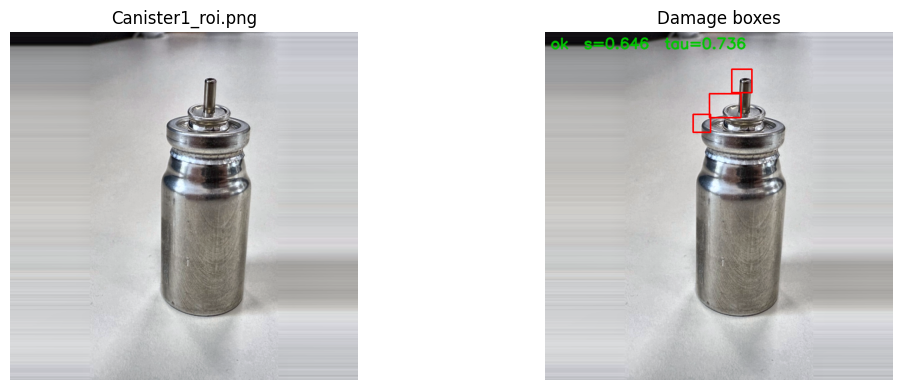

✓ Saved: Canister2_comparison.png


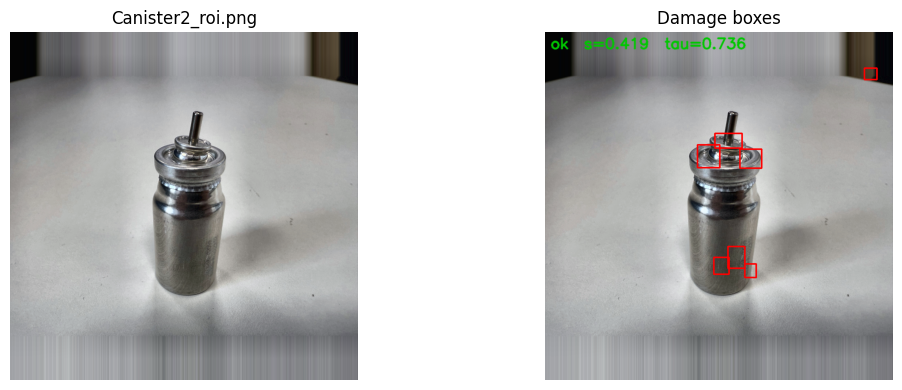

✓ Saved: Canister3_comparison.png


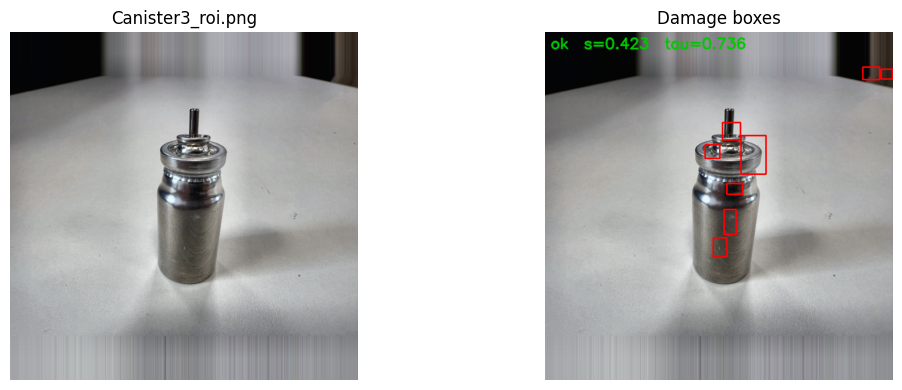

✓ Saved: Canister4_comparison.png


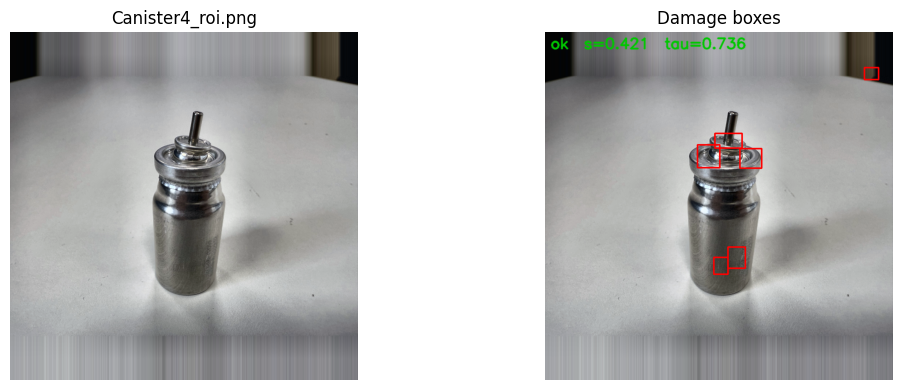

✓ Saved: Canister5_comparison.png


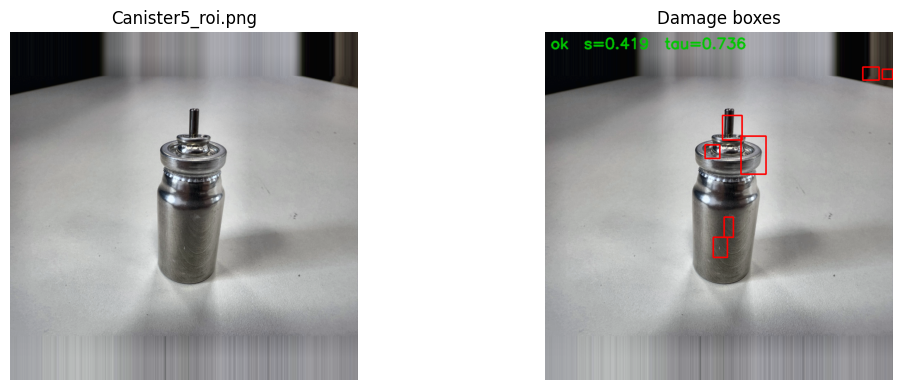


✅ ALL COMPARISON IMAGES SAVED TO: content/data/output/


In [ ]:
def predict(image_path: str) -> Dict[str,Any]:
    img = load_image(image_path)
    m   = load_image(image_path.replace('_roi.png','_mask.png'))
    out = image_anomaly_masked(img, m, memory, model, device, topk_percent=TOPK_PERCENTILE)
    label = 'damaged' if out['score'] >= tau else 'ok'
    if abs(out['score']-tau) <= tau*UNCERTAIN_BAND:
        label += ' (uncertain)'
    blend = overlay_heatmap_masked(img, out['heatmap'], m, alpha=ALPHA, clip_p=HEAT_CLIP)
    boxes = anomaly_boxes_from_heat(out['heatmap'], m, percentile=BOX_PERCENTILE,
                                    min_area_px=BOX_MIN_AREA, pad_px=BOX_PAD)
    boxed = draw_red_boxes(img, boxes, label=f"{label}  s={out['score']:.3f}  tau={tau:.3f}")
    return {'path': image_path, 'label': label, 'score': float(out['score']), 'tau': float(tau),
            'blend': blend, 'boxed': boxed, 'boxes': boxes}

# for p in roi_imgs:
#     r = predict(p)
#     plt.figure(figsize=(12,4))
#     plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(load_image(p), cv2.COLOR_BGR2RGB)); plt.title(os.path.basename(p)); plt.axis('off')
#     # plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(r['blend'], cv2.COLOR_BGR2RGB)); plt.title('Masked heatmap'); plt.axis('off')
#     plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(r['boxed'], cv2.COLOR_BGR2RGB)); plt.title('Damage boxes'); plt.axis('off')
#     plt.show()

# Create output folder
output_folder = './data/output'
os.makedirs(output_folder, exist_ok=True)
print(f"💾 Saving outputs to: {output_folder}/\n")

for p in roi_imgs:
    r = predict(p)
    
    # Get base filename
    base_name = os.path.basename(p).replace('_roi.png', '')
    
    # Create figure with 2 subplots
    fig = plt.figure(figsize=(12, 4))
    
    # Subplot 1: Original
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(load_image(p), cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(p))
    plt.axis('off')
    
    # Subplot 2: Damage boxes
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(r['boxed'], cv2.COLOR_BGR2RGB))
    plt.title('Damage boxes')
    plt.axis('off')
    
    plt.tight_layout()
    
    # Save the figure before showing it
    output_path = f"{output_folder}/{base_name}_comparison.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {base_name}_comparison.png")
    
    # Display
    plt.show()

print(f"\n{'='*70}")
print(f"✅ ALL COMPARISON IMAGES SAVED TO: {output_folder}/")
print(f"{'='*70}")


## 8) Save memory & config

In [ ]:
import pickle, yaml, os
os.makedirs('./models/patchcore', exist_ok=True)
with open('./models/patchcore/memory.pkl', 'wb') as f:
    pickle.dump({'memory': memory.astype(np.float32)}, f)

CFG = dict(DATA_ROOT=DATA_ROOT, ROI_DIR=ROI_DIR, BACKBONE=backbone_name, FEATURE_OUT_INDEX=FEATURE_OUT_INDEX,
           INPUT_SHORT=INPUT_SHORT, BBOX_PAD_FRAC=BBOX_PAD_FRAC, FG_INSET=FG_INSET, BG_MARGIN=BG_MARGIN,
           BORDER_KILL_PCT=BORDER_KILL_PCT, CLOSE_KS=CLOSE_KS, OPEN_KS=OPEN_KS, MIN_AREA_FRAC=MIN_AREA_FRAC,
           KNN_K=KNN_K, PSEUDO_OK_KEEP_PERCENT=PSEUDO_OK_KEEP_PERCENT, CORESET_FRAC=CORESET_FRAC,
           TOPK_PERCENTILE=TOPK_PERCENTILE, TAU_METHOD=TAU_METHOD, TAU_PERCENTILE=TAU_PERCENTILE,
           UNCERTAIN_BAND=UNCERTAIN_BAND, HEAT_CLIP=HEAT_CLIP, ALPHA=ALPHA,
           CONTOUR_PCT=CONTOUR_PCT, BOX_PERCENTILE=BOX_PERCENTILE, BOX_MIN_AREA=BOX_MIN_AREA, BOX_PAD=BOX_PAD)
with open('./models/patchcore/config.yaml', 'w') as f:
    yaml.safe_dump(CFG, f)
print('Saved memory + config to /content/models/patchcore/')


Saved memory + config to /content/models/patchcore/
